# Deep dive into SST skill
There are a few features of the SST skill that I'd like to understand better:

1) Negative 4-year correlation in the Western Tropical Pacific that substantially goes away over longer verification periods
2) Poor MSSS in CAFE-f6 in the Southern Ocean
3) "Better" initialised component of ACC for CAFE-f6 than other models, but "worse" MSSS_hist

In [1]:
import warnings

warnings.filterwarnings("ignore")

import cftime

import numpy as np
import xarray as xr
import xskillscore as xs

import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import dask

dask.config.set(**{"array.slicing.split_large_chunks": False})

from src import plot, utils, verify

DATA_DIR = "../../data/"

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [3]:
plt.rcParams["figure.figsize"] = (12, 4)

## 1) Negative 4-year correlation in Western Tropical Pacific that substantially goes away over longer verification periods

An example (similar behaviour is observed for all models):

In [4]:
s = xr.open_zarr(
    f"{DATA_DIR}/skill/CanESM5.HadISST.4-year.anom_1985-2014.sst_global.rXY_1985-2014.zarr"
)

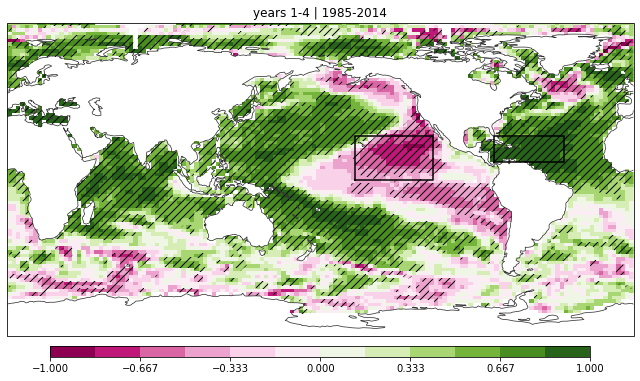

In [5]:
f = plot.metric_maps(
    [[s.sel(lead=59).compute()]],
    variable="sst",
    vrange=(-1, 1),
    headings=[["years 1-4"]],
    figsize=(9, 5),
)

ETP_box = [200, 245, 0, 25]
WTA_box = [280, 320, 10, 25]


def plot_box(ax, box):
    import cartopy.crs as ccrs

    ax.plot(
        [box[0], box[1], box[1], box[0], box[0]],
        [box[2], box[2], box[3], box[3], box[2]],
        "k",
        transform=ccrs.PlateCarree(),
    )


for box in [ETP_box, WTA_box]:
    plot_box(f.axes[0], box)

Let's look at some timeseries in these regions

In [8]:
f5 = xr.open_zarr(f"{DATA_DIR}/processed/CAFEf5.4-year.anom_1991-2020.sst_global.zarr")

f6 = xr.open_zarr(f"{DATA_DIR}/processed/CAFEf6.4-year.anom_1991-2020.sst_global.zarr")

can = xr.open_zarr(
    f"{DATA_DIR}/processed/CanESM5.4-year.anom_1985-2014.sst_global.zarr"
)

ec = xr.open_zarr(
    f"{DATA_DIR}/processed/EC_Earth3.4-year.anom_1985-2014.sst_global.zarr"
)
had = xr.open_zarr(
    f"{DATA_DIR}/processed/HadISST.4-year.anom_1991-2020.sst_global.zarr"
)
d60 = xr.open_zarr(
    f"{DATA_DIR}/processed/CAFE60v1.4-year.anom_1991-2019.sst_global.zarr"
)

f5["ETP"] = utils.extract_lon_lat_box(
    f5.mean("member"), ETP_box, weighted_average=True
)["sst"]
f6["ETP"] = utils.extract_lon_lat_box(
    f6.mean("member"), ETP_box, weighted_average=True
)["sst"]
can["ETP"] = utils.extract_lon_lat_box(
    can.mean("member"), ETP_box, weighted_average=True
)["sst"]
ec["ETP"] = utils.extract_lon_lat_box(
    ec.mean("member"), ETP_box, weighted_average=True
)["sst"]
had["ETP"] = utils.extract_lon_lat_box(had, ETP_box, weighted_average=True)[
    "sst"
].compute()
d60["ETP"] = utils.extract_lon_lat_box(
    d60.mean("member"), ETP_box, weighted_average=True
)["sst"].compute()

f5["WTA"] = utils.extract_lon_lat_box(
    f5.mean("member"), WTA_box, weighted_average=True
)["sst"]
f6["WTA"] = utils.extract_lon_lat_box(
    f6.mean("member"), WTA_box, weighted_average=True
)["sst"]
can["WTA"] = utils.extract_lon_lat_box(
    can.mean("member"), WTA_box, weighted_average=True
)["sst"]
ec["WTA"] = utils.extract_lon_lat_box(
    ec.mean("member"), WTA_box, weighted_average=True
)["sst"]
had["WTA"] = utils.extract_lon_lat_box(had, WTA_box, weighted_average=True)[
    "sst"
].compute()
d60["WTA"] = utils.extract_lon_lat_box(
    d60.mean("member"), WTA_box, weighted_average=True
)["sst"].compute()

ValueError: Dataset does not contain the dimensions: ['member']

In [9]:
norm_period = ["1991-01-01", "2020-12-31"]

f5_norm = f5 / utils.keep_period(f5, norm_period).std("init")
f6_norm = f6 / utils.keep_period(f6, norm_period).std("init")
can_norm = can / utils.keep_period(can, norm_period).std("init")
ec_norm = ec / utils.keep_period(ec, norm_period).std("init")
had_norm = had / utils.keep_period(had, norm_period).std("time")
d60_norm = d60 / utils.keep_period(d60, norm_period).std("time")

In [ ]:
def plot_timeseries(hindcasts, observations, ax):
    from itertools import cycle

    for name, hindcast in hindcasts.items():
        hindcast.plot(ax=ax, label=name)

    lines = ["-", "--", "-.", ":"]
    linecycler = cycle(lines)
    for name, observation in observations.items():
        observation.plot(ax=ax, label=name, color="k", linestyle=next(linecycler))

    ax.legend()

In [ ]:
def get_lead(ds, lead):
    return ds.sel(lead=lead).swap_dims({"init": "time"})

In [ ]:
lead = 59

fig = plt.figure(figsize=(10, 7))
axs = fig.subplots(2, 1, sharex=True)

for ax, region in zip(axs, ["ETP", "WTA"]):
    plot_timeseries(
        {
            "CAFE-f5": get_lead(f5[region], lead),
            "CAFE-f6": get_lead(f6[region], lead),
            "CanESM5": get_lead(can[region], lead),
            "EC-Earth3": get_lead(ec[region], lead),
        },
        {"HadISST": had[region], "CAFE60v1": d60[region]},
        ax,
    )

In [ ]:
verif_period = ["1991-01-01", "2020-12-31"]

can_period = utils.keep_period(get_lead(can[["ETP", "WTA"]], lead), verif_period)
xs.pearson_r(
    can_period, had[["ETP", "WTA"]].sel(time=can_period.time), dim="time"
).compute()

In [ ]:
verif_period = ["1985-01-01", "2014-12-31"]

can_period = utils.keep_period(get_lead(can[["ETP", "WTA"]], lead), verif_period)
xs.pearson_r(
    can_period, had[["ETP", "WTA"]].sel(time=can_period.time), dim="time"
).compute()

So the correlation (and other metrics) is clearly very sensitive to the verification period. Can we try to quantify this, e.g. by subsampling the CanESM5 data? 

In [ ]:
def metric_sample_length_sensitivity(*timeseries, blocksize, metric):
    """
    Test the sensitivity of a metric to the sample length by calculating the metric
    on randomly sampled blocks of specified lengths

    Parameters
    ----------
    timeseries: xarray Datasets
        The timeseries required to calculate the metric, e.g. hindcasts and observations
    blocksize: int or list of int
        The blocksize to recalculate the metric for
    """

    def _n_random_block_indices(size, blocksize):
        """
        Returns indices to randomly resample a single block of a specified length multiple
        times from an array.
        """
        block_starts = np.arange(0, size - blocksize + 1)
        increment = np.arange(blocksize)
        return block_starts + np.expand_dims(increment, axis=1)

    def _sample_blocks(*arrays, indices):
        """Bootstrap the array(s) using the provided indices"""
        blocks = [array[indices] for array in arrays]
        if len(blocks) == 1:
            return blocks[0]
        else:
            return tuple(blocks)

    timeseries = xr.align(*timeseries)
    metric = getattr(verify, metric)

    indices = _n_random_block_indices(timeseries[0].sizes["time"], blocksize)

    timeseries_blocks = []
    for obj in timeseries:
        timeseries_blocks.append(
            xr.apply_ufunc(
                _sample_blocks,
                obj,
                kwargs=dict(
                    indices=(..., indices),
                ),
                input_core_dims=[["time"]],
                output_core_dims=[["time", "iteration"]],
                exclude_dims=set(["time"]),
                dask="parallelized",
                dask_gufunc_kwargs=dict(
                    output_sizes={"time": blocksize, "iteration": indices.shape[-1]}
                ),
                output_dtypes=[obj[list(obj.data_vars)[0]].dtype],
            )
        )

    return verify._calculate_metric_from_timeseries(
        *timeseries_blocks, metric=metric, metric_kwargs={}, significance=False
    )

In [7]:
region = "WTA"

sensitivity = {}
blocksizes = list(range(5, 60, 5)) + [57]
for blocksize in blocksizes:
    sensitivity[blocksize] = metric_sample_length_sensitivity(
        get_lead(can, lead)[[region]],
        had[[region]],
        blocksize=blocksize,
        metric="rXY",
    )

NameError: name 'metric_sample_length_sensitivity' is not defined

In [ ]:
x = []
y = []
for b, d in sensitivity.items():
    x.extend([int(b)] * d.sizes["iteration"])
    y.extend(d[region].values)

p = sns.violinplot(
    x=x,
    y=y,
    bw=0.2,
    cut=0,
    inner="stick",
    scale="width",
)

p.set_xlabel("Sample size (years)")
p.set_ylabel(f"ACC in {region}")

In [ ]:
a, b = xr.align(get_lead(can, lead)["sst"].mean("member"), had["sst"])

eff_sample_size = xs.effective_sample_size(a, b, dim="time")

## 2) Poor MSSS in CAFE-f6 in the Southern Ocean

## 3) "Better" initialised component of ACC for CAFE-f6 than other models, but "worse" MSSS_hist

## Something that might be revealing is to compare our forecasts to their own analysis (CAFE60v1)